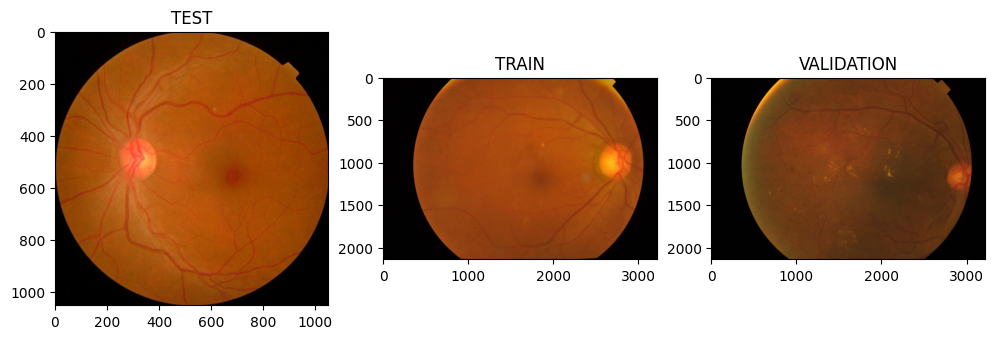

In [1]:
import matplotlib.pyplot as plt
import glob


test_image_path = "/users/0/chan2497/APTOS/test_images/test_images"
train_image_path = "/users/0/chan2497/APTOS/train_images/train_images"
val_image_path = "/users/0/chan2497/APTOS/val_images/val_images"

test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

test_image = test_images[0]
train_image = train_images[0]
val_image = val_images[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(plt.imread(test_image), cmap='gray')
ax[0].set_title('TEST')

ax[1].imshow(plt.imread(train_image), cmap='gray')
ax[1].set_title('TRAIN')

ax[2].imshow(plt.imread(val_image), cmap='gray')
ax[2].set_title('VALIDATION')

plt.show()

In [2]:
import torch
import numpy as np

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Device: {device}")

2.1.2
Device: cuda


In [3]:
from typing import Tuple, Any
from functools import lru_cache
from torchvision.datasets import ImageFolder as _ImageFolder

class ImageFolder(_ImageFolder):
    """
    The ImageFolder provided by torchvision reads from memory every time it's
    indexed. Here, we use an LRU cache so that each image is only read from
    memory once. This will require ~1.5 gigabyte of RAM.

    Compared to the naive implementation, this speeds up training ~60x.
    """
    @lru_cache(maxsize = 10_000)
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
#TODO: update these values
#target_size = (112, 112)

transform = transforms.Compose([
    # Resize images to 819x614/ resize images to smaller dims 224x224
    #transforms.Resize((819,614),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Resize((224, 224), interpolation=3),
    # Center at 600x600/ center to 200x200 
    transforms.CenterCrop(200),
    # Convert images to tensors
    transforms.ToTensor(),
    # Normalize with ImageNet mean and standard deviation ( a common practice )
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets. Use images under 'train' folder for train_dataset and under 'test' folder for test_dataset
train_dataset = ImageFolder("/users/0/chan2497/APTOS/train_images", transform)
val_dataset = ImageFolder("/users/0/chan2497/APTOS/val_images", transform)
test_dataset = ImageFolder("/users/0/chan2497/APTOS/test_images", transform)


# Create data loaders, use a batch size of '64', set shuffle to 'False' and workers to '0'
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


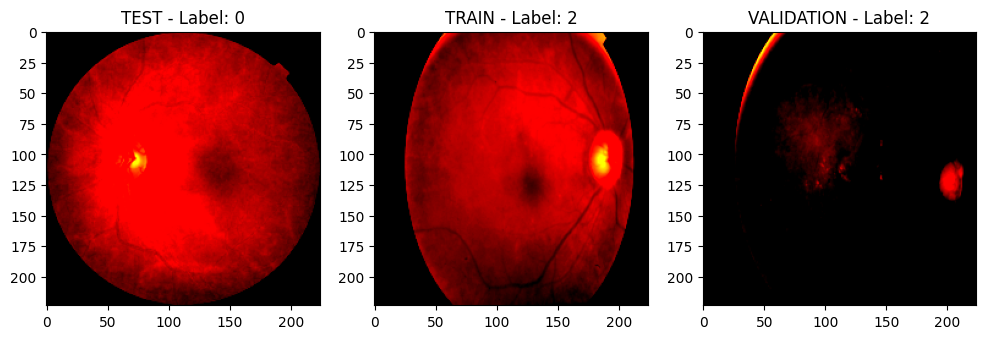

In [5]:
import pandas as pd
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Paths to images and labels
test_image_path = "/users/0/chan2497/APTOS/test_images/test_images"
train_image_path = "/users/0/chan2497/APTOS/train_images/train_images"
val_image_path = "/users/0/chan2497/APTOS/val_images/val_images"

train_csv_path = "/users/0/chan2497/APTOS/train_1.csv.xls"
val_csv_path = "/users/0/chan2497/APTOS/valid.csv.xls"
test_csv_path = "/users/0/chan2497/APTOS/test.csv.xls"

# Load labels from Excel files
train_labels = pd.read_csv(train_csv_path)
val_labels = pd.read_csv(val_csv_path)
test_labels = pd.read_csv(test_csv_path)

# Sort image paths
test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and transform the first image from each set
def load_and_transform(image_path, transform):
    image = Image.open(image_path)
    transformed_image = transform(image)
    transformed_image = transformed_image.permute(1, 2, 0).numpy()  # Convert for visualization
    return transformed_image

# Extract the first image and corresponding label
train_image_transformed = load_and_transform(train_images[0], transform)
val_image_transformed = load_and_transform(val_images[0], transform)
test_image_transformed = load_and_transform(test_images[0], transform)

# Get corresponding labels
def get_label(image_path, labels_df):
    image_id = image_path.split('/')[-1].replace('.png', '')
    label = labels_df.loc[labels_df['id_code'] == image_id, 'diagnosis']
    return label.values[0] if not label.empty else "Label Not Found"

train_label = get_label(train_images[0], train_labels)
val_label = get_label(val_images[0], val_labels)
test_label = get_label(test_images[0], test_labels)

# Plot the transformed images with their labels
fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(test_image_transformed)
ax[0].set_title(f'TEST - Label: {test_label}')

ax[1].imshow(train_image_transformed)
ax[1].set_title(f'TRAIN - Label: {train_label}')

ax[2].imshow(val_image_transformed)
ax[2].set_title(f'VALIDATION - Label: {val_label}')

plt.show()


In [6]:
from tqdm.auto import tqdm


def verify_loader_size(dataloader, dataset):
    samples = 0
    for batch, labels in tqdm(dataloader):
        samples += len(batch)
    return samples == len(dataset)

# This will take awhile as the images are loaded into memory and cached for the first time.
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and 
    verify_loader_size(valid_loader, val_dataset)
)


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
# Notice how much faster it is after caching!
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and 
    verify_loader_size(valid_loader, val_dataset)
)

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
def plot_learning_curves(training_losses, validation_losses):
    # Plot epoch wise training and validation losses (both in the same plot)
    assert len(training_losses) == len(validation_losses)

    # YOUR CODE HERE
    plt.figure(figsize=(10,6))
    plt.plot(training_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(validation_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

In [10]:

import torch
from torch import nn, optim
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from tqdm import tqdm

# Step 1: Initialize the model
def initialize_model(num_classes, device):
    # Load a pre-trained EfficientNet-B7 model 
    weights = EfficientNet_B7_Weights.DEFAULT
    model = efficientnet_b7(weights=weights)
    
    # classifier layer 
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
    
    # Move model to the specified device (CPU or GPU)
    model = model.to(device)
    
    return model

# Step 2: Train the model
def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='efficientnetb7', epochs=20):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')  # Track the best validation loss

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='batch')

        for inputs, labels in progress_bar:
            # Move data to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_module(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        training_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss / len(valid_loader)
        validation_losses.append(valid_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

        # Save the best model
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch + 1}, f"{path}_best.pth")
            print(f"Best model saved at epoch {epoch + 1}")

        # Save the model at the end of each epoch
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch + 1}, f"{path}_epoch_{epoch + 1}.pth")

    return training_losses, validation_losses

# Step 3: Specify parameters and train the model
if __name__ == "__main__":
    # Define device (use GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Check dataset classes
    try:
        num_classes = len(train_dataset.classes)
    except NameError:
        raise ValueError("train_dataset is not defined. Ensure train_dataset is correctly loaded.")

    # Initialize the model
    model = initialize_model(num_classes, device)

    # Define loss function and optimizer
    loss_module = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # Ensure train_loader and valid_loader are defined
    try:
        train_losses, val_losses = train_model(
            model, loss_module, optimizer, train_loader, valid_loader, 
            device=device, path="efficientnetb7", epochs=20
        )
    except NameError:
        raise ValueError("train_loader or valid_loader is not defined. Ensure data loaders are properly initialized.")

Epoch 1/20, Train Loss: 0.8361, Valid Loss: 0.0126
Best model saved at epoch 1


Epoch 2/20, Train Loss: 0.0356, Valid Loss: 0.0042
Best model saved at epoch 2


Epoch 3/20, Train Loss: 0.0098, Valid Loss: 0.0069


Epoch 4/20, Train Loss: 0.0055, Valid Loss: 0.0035
Best model saved at epoch 4


Epoch 5/20, Train Loss: 0.0036, Valid Loss: 0.0024
Best model saved at epoch 5


Epoch 6/20, Train Loss: 0.0025, Valid Loss: 0.0016
Best model saved at epoch 6


Epoch 7/20, Train Loss: 0.0020, Valid Loss: 0.0017


Epoch 8/20, Train Loss: 0.0016, Valid Loss: 0.0014
Best model saved at epoch 8


Epoch 9/20, Train Loss: 0.0014, Valid Loss: 0.0017


Epoch 10/20, Train Loss: 0.0011, Valid Loss: 0.0011
Best model saved at epoch 10


Epoch 11/20, Train Loss: 0.0009, Valid Loss: 0.0007
Best model saved at epoch 11


Epoch 12/20, Train Loss: 0.0008, Valid Loss: 0.0008


Epoch 13/20, Train Loss: 0.0007, Valid Loss: 0.0006
Best model saved at epoch 13


Epoch 14/20, Train Loss: 0.0006, Valid Loss: 0.0005
Best model saved at epoch 14


Epoch 15/20, Train Loss: 0.0006, Valid Loss: 0.0007


Epoch 16/20, Train Loss: 0.0005, Valid Loss: 0.0005
Best model saved at epoch 16


Epoch 17/20, Train Loss: 0.0005, Valid Loss: 0.0005
Best model saved at epoch 17


Epoch 18/20, Train Loss: 0.0004, Valid Loss: 0.0004
Best model saved at epoch 18


Epoch 19/20, Train Loss: 0.0004, Valid Loss: 0.0006


Epoch 20/20, Train Loss: 0.0004, Valid Loss: 0.0004
Best model saved at epoch 20


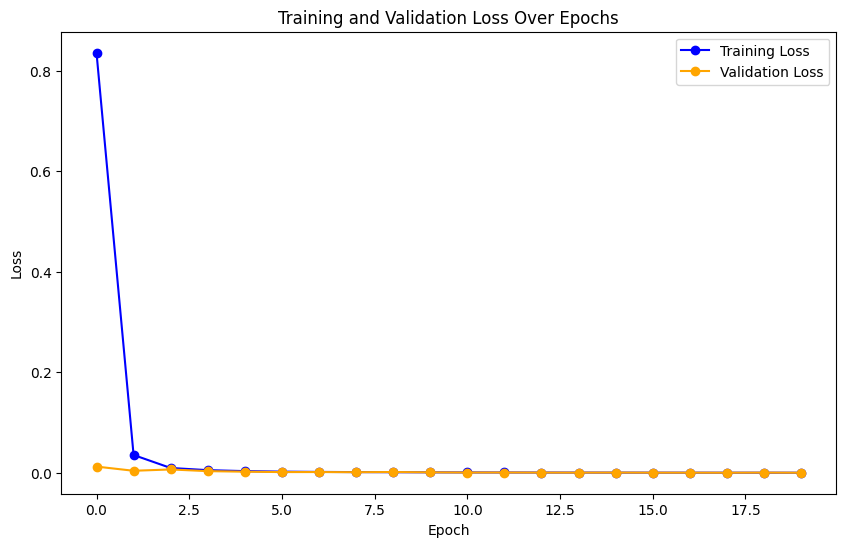

In [11]:
# Plot learning curves
plot_learning_curves(train_losses, val_losses)

In [18]:
from tqdm import tqdm


def train_model(model, loss_module, optimizer, train_loader, valid_loader, device, path='model', epochs=20):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        # Set model to train mode
        model.train()

        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{epochs}", leave=False, unit='mini-batch')
        best_val_loss = float('inf')
        # Batch loop
        for inputs, labels in progress_bar:

            # Move input data to device (only strictly necessary if we use GPU)
            print("labels range:", torch.min(labels), torch.max(labels))
            inputs, labels = inputs.to(device), labels.to(device)

            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()

            # Run the model on the input data and compute the outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_module (outputs, labels)
            print("output range:", torch.min(outputs), torch.max(outputs))

            # Perform backpropagation
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Calculate the loss for current iteration
            running_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss/len(train_loader)

        # Set model to eval mode for validation
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                # For validation batches, calculate the output, and loss in a similar way
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model (inputs)
                loss = loss_module(outputs, labels)
                running_loss += loss.item()

        valid_loss = running_loss/len(valid_loader)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f},  Valid Loss: {valid_loss:.4f}')
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch+1
            torch.save(model.state_dict(), path+ f"_best.tar")
        # Save the model's state_dict at end of each epoch
        torch.save(model.state_dict(), path + f".tar")

        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

    return training_losses, validation_losses

# Shallow CNN

In [23]:
from torch import nn

class CNNShallow(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNShallow, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Placeholder for dynamically computed fc input size
        self.flatten_size = None
        self.fc = None  # Initialize later based on flattened size
        
        # Call helper to calculate flattened size
        self._initialize_fc(num_classes)

    def _initialize_fc(self, num_classes):
        # Use a dummy input to determine fc input size
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)  # Use the same input size as your data
            x = self.pool2(self.conv2(self.pool1(self.conv1(dummy_input))))
            self.flatten_size = x.numel()  # Compute flattened size
        self.fc = nn.Linear(self.flatten_size, num_classes)  # Update fc layer

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Instantiate the model
cnn_model = CNNShallow()

print(cnn_model)

CNNShallow(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=200704, out_features=2, bias=True)
)


In [24]:
from torchsummary import summary

summary(cnn_model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Linear-5                    [-1, 2]         401,410
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 22.97
Params size (MB): 1.61
Estimated Total Size (MB): 25.15
----------------------------------------------------------------


In [25]:
cnn_model.to(device)

loss_module = torch.nn.CrossEntropyLoss()

# You can use '0.0001' as learning rate for the optimizer
optimizer = torch.optim.Adam(params = cnn_model.parameters(), lr=0.0001)

training_losses, validation_losses = train_model(
    cnn_model, loss_module, optimizer, train_loader, valid_loader, device, 'cnn-shallow'
)
plot_learning_curves(training_losses, validation_losses)

labels range: tensor(0) tensor(0)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x160000 and 200704x2)

# Testing

In [ ]:
from sklearn.metrics import roc_curve, auc

def test_model(model, test_loader):

    true_labels = []

    # predicted probabilities have probability that a sample belongs to positive class (having pneumonia)
    predicted_probabilities = []

    # Set model to eval mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get the predicted class indices
            _, predicted = torch.max(outputs,1)

            true_labels.extend(labels.cpu().numpy())

            # Compute softmax probabilities for each class and select the probability of the positive class
            probs = torch.softmax(outputs, dim=1)[:,1]

            predicted_probabilities.extend(probs.cpu().numpy())

    return true_labels, predicted_probabilities

def plot_roc_curve(labels, probs):

    # Compute and plot the ROC curve and specify the AUC value in the legend (or within the plot somewhere).
    fpr, tpr, thresholds = roc_curve(labels, probs)
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {auc_val:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
# Load the model from the epoch you deem optimal

cnn_model = CNNShallow()
cnn_model.load_state_dict(torch.load("cnn-shallow_best.tar"))
cnn_model.to(device)

true_labels, predicted_probabilities = test_model(cnn_model, test_loader)

assert(len(true_labels) == len(predicted_probabilities))

In [ ]:
plot_roc_curve(true_labels, predicted_probabilities)